In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import random
random.seed(30)

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# AUX_DATA_ROOT is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Project Data/portfolio_data")
else:
    AUX_DATA_ROOT = Path("./portfolio_data")

(105120, 4)

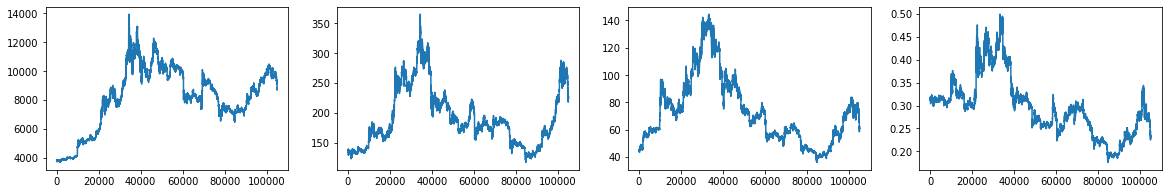

In [3]:
# uploading unnormalised LOB data
num_tokens = 4
btc = np.load(os.path.join(AUX_DATA_ROOT, 'unnormalised_BTCUSDT_5.npy'))
eth = np.load(os.path.join(AUX_DATA_ROOT, 'unnormalised_ETHUSDT.npy'))
ltc = np.load(os.path.join(AUX_DATA_ROOT, 'unnormalised_LTCUSDT.npy'))
xrp = np.load(os.path.join(AUX_DATA_ROOT, 'unnormalised_XRPUSDT.npy'))
len_btc, len_eth = len(btc), len(eth)

# calculating mid prices
prices_5 = []
for x in [btc, eth, ltc, xrp]:
    mid_prices = []
    for point in x:
      mid_prices += [(point[0][0] +point[2][0])/2]
    prices_5.append(mid_prices[:len_eth])

fig, ax = plt.subplots(1,4, figsize = (20,3))
for i in range(4):
  ax[i].plot(prices_5[i])
prices = np.array(prices_5).T
prices.shape

In [4]:
# calculating returns of each asset
returns = []
for i in range(1, len(prices)):
  returns.append((prices[i] - prices[i-1])/prices[i-1])
returns_h =  np.array(returns)
print(returns_h.shape)
prices = np.array(prices[:len(prices)-1,:])
prices.shape

(105119, 4)


(105119, 4)

In [5]:
# uploading true labels
labels = []
before = len(np.load(os.path.join(AUX_DATA_ROOT, 'labels_ETHUSDT_10.npy')))
labels.append(np.load(os.path.join(AUX_DATA_ROOT, 'labels_BTCUSDT_5_10.npy'))[:before])
labels.append(np.load(os.path.join(AUX_DATA_ROOT, 'labels_ETHUSDT_10.npy'))[:before])
labels.append(np.load(os.path.join(AUX_DATA_ROOT, 'labels_LTCUSDT_10.npy'))[:before])
labels.append(np.load(os.path.join(AUX_DATA_ROOT, 'labels_XRPUSDT_10.npy'))[:before])
labels = np.array(labels).T
labels.shape

(102229, 4)

In [6]:
# uploading predicted labels and set the same lenght for each list

labels_pred = []
diff = len(np.load(os.path.join(AUX_DATA_ROOT, 'btc_pred.npy'))) - len(np.load(os.path.join(AUX_DATA_ROOT, 'eth_pred.npy')))
np.load(os.path.join(AUX_DATA_ROOT, 'labels_XRPUSDT_10.npy'))
labels_pred.append(np.load(os.path.join(AUX_DATA_ROOT, 'btc_pred.npy'))[diff:])
labels_pred.append(np.load(os.path.join(AUX_DATA_ROOT, 'eth_pred.npy')))
labels_pred.append(np.load(os.path.join(AUX_DATA_ROOT, 'ltc_pred.npy'))[diff:])
labels_pred.append(np.load(os.path.join(AUX_DATA_ROOT, 'xrp_pred.npy'))[diff:])

labels_pred = np.array(labels_pred)
print(labels_pred.shape)
labels_pred_argmax = labels_pred.argmax(axis=2).T
labels_pred_argmax.shape

(4, 10163, 3)


(10163, 4)

In [7]:
# split arrays for test and train
split = int(0.9 * len_eth)
prices_train, prices_test = prices[:split,:], prices[split:,:]
print('train shape: ', prices_train.shape, 'test shape: ', prices_test.shape)
labels_train, labels_test = labels[:split,:], labels[split:,:]
print('train shape: ', labels_train.shape, 'test shape: ', labels_test.shape)
returns_train = returns_h[:split,:]
labels_pred_argmax.shape

train shape:  (94608, 4) test shape:  (10511, 4)
train shape:  (94608, 4) test shape:  (7621, 4)


(10163, 4)

In [8]:
returns_test = [(prices_test[0,:] - prices_train[-1,:]) / prices_train[-1,:]]
for i in range(1, len(prices_test)):
  returns_test.append((prices_test[i] - prices_test[i-1])/prices_test[i-1])
returns_test = np.array(returns_test)
returns_test.shape

(10511, 4)

In [3]:
class PortfolioLSTM(nn.Module):
    '''
    LSTM model for weights optimization.
    '''
    def __init__(self, n_features, num_tokens=4, lstm_units=64):
        super(PortfolioLSTM, self).__init__()
        
        self.lstm = nn.LSTM(n_features, lstm_units, batch_first=True)
        self.fc_out = nn.Linear(lstm_units, num_tokens)
    
    def forward(self, x):
        # x = (batch_size, T, n_features)
        x, _ = self.lstm(x)
        x = self.fc_out(x).softmax(axis = 2)
        return x

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, T = 0):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        self.T = T

    def __len__(self):
        return self.X.shape[0] - self.T
    
    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx,:]

# calculate returns, prices and labels with k=10 step (50 minutes)
returns_50_train = []
for i in range(8, prices_train.shape[0], 10):
    returns_50_train.append((prices_train[i] - prices_train[i-10]) / prices_train[i-10])
returns_50_train = np.array(returns_50_train)

returns_50_test = [(prices_test[0] - prices_train[-10]) / prices_train[-10]]
for i in range(8, prices_test.shape[0], 10):
    returns_50_test.append((prices_test[i] - prices_test[i-10]) / prices_test[i-10])
returns_50_test = np.array(returns_50_test[1:])

labels_train_50 = []
for i in range(8, labels_train.shape[0], 10):
  labels_train_50.append(labels_train[i])
labels_train_50 = np.array(labels_train_50)

# Create Datasets
X_train = torch.Tensor(labels_train_50)
X_test = torch.Tensor(labels_pred_argmax)[:len(labels_pred_argmax)-3]
X_train, X_test = X_train.reshape(-1, 10, 4), X_test.reshape(-1, 10, 4)

y_test, y_train = torch.Tensor(returns_50_test), torch.Tensor(returns_50_train)

print('train shape:', y_train.shape, 'test shape: ', y_test.shape)
print('train shape:', X_train.shape, 'test shape: ', X_test.shape)
        
train_dataset = Dataset(X_train, y_train, T = 0)
test_dataset = Dataset(X_test, y_test, T = 0)

bs = 64
labels_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train shape: torch.Size([9460, 4]) test shape:  torch.Size([1051, 4])
train shape: torch.Size([946, 10, 4]) test shape:  torch.Size([1016, 10, 4])


In [0]:
class SR_loss(nn.Module):
    '''
    Sharpe ratio - expected return over volatility 
    excluding risk-free rate in our case
    '''
    def __init__(self):
        super(SR_loss, self).__init__()

    def forward(self, weights, returns):
        R = torch.sum(weights * returns, axis = 1)
        std = torch.std(R)
        loss = R.mean() / torch.max(torch.Tensor([std, (1e-5)]))
        return -loss

class MV_loss(nn.Module):
    '''
    Volatility - standard deviation of portfoio returns
    '''
    def __init__(self):
        super(MV_loss, self).__init__()

    def forward(self, weights, returns):
        R = torch.sum(weights * returns, axis = 1)
        std = torch.std(R)
        return std

class MDD_loss(nn.Module):
    '''
    Maximum Drawdown - the biggest loss from a peak to a trough
    '''
    def __init__(self):
        super(MDD_loss, self).__init__()

    def forward(self, weights, returns):
        R = torch.sum(weights * returns, axis = 1)
        #loss = 1 - R / torch.cummax(R, dim = 0).values

        MDD = 0
        peak = R[0]
        for i in R:
            if i > peak: 
                peak = i
            drop = (peak - i) / peak
            if drop > MDD:
                mdd = drop
        return -mdd

In [0]:
def train(model, criterion, optimizer, train_loader, num_epoch = 100, size = num_tokens*10):
  '''
  Here we train our LSTM model
  '''
  train_loss = []
  loss_best = 1000

  for epoch in range(1, num_epoch+1):
      running_loss = 0

      for x, y in train_loader:
          optimizer.zero_grad()
          x = x.reshape(x.shape[0],-1, size).to(device)
          #print(x[0,:,2:5])

          y = y.to(device)   
          pred = model(x)
          #returns = x[0,:,2:5]
          #print(pred.shape, y.shape)
          loss = criterion(pred.mean(axis=1), y)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      if running_loss/len(train_loader) < loss_best:
          loss_best = running_loss/len(train_loader) 
          model_best = model

      train_loss.append(running_loss/len(train_loader))
      if epoch % 25 == 0:
        print('Epoch:', epoch)
        print('Training Loss: {:.6f},'.format(train_loss[-1]))
  return model_best

In [0]:
DO_TRAIN = False

if DO_TRAIN == True:
  w_lstm_lab = []
  for criterion, title in zip([SR_loss(), MV_loss(), MDD_loss()], ['SR.pth', 'MV.pth', 'MDD.pth']):
    model = PortfolioLSTM(num_tokens*10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.to(device)
    model = train(model, criterion, optimizer, labels_dataloader, num_epoch=100)

    #path = os.path.join(AUX_DATA_ROOT, './checkpoint_'+title)
    #torch.save(model.state_dict(), path)

    pred_weights = []
    with torch.no_grad():
      for x in X_test:
        pred = model(x.reshape(1, -1,num_tokens*10).to(device)).cpu().numpy()
        pred = pred[0][0]
        pred_weights.append(pred)
    w_lstm_lab.append(pred_weights)


if DO_TRAIN == False:
    w_lstm_lab = []
    for title in ['SR.pth', 'MV.pth', 'MDD.pth']:
      model = PortfolioLSTM(num_tokens*10)
      path = './weights/portfolio/checkpoint_'+title
      model.load_state_dict(torch.load(path, map_location='cpu'))

      pred_weights = []
      with torch.no_grad():
        for x in X_test:
          pred = model(x.reshape(1, -1,num_tokens*10)).cpu().numpy()
          pred = pred[0][0]
          pred_weights.append(pred)
      w_lstm_lab.append(pred_weights)

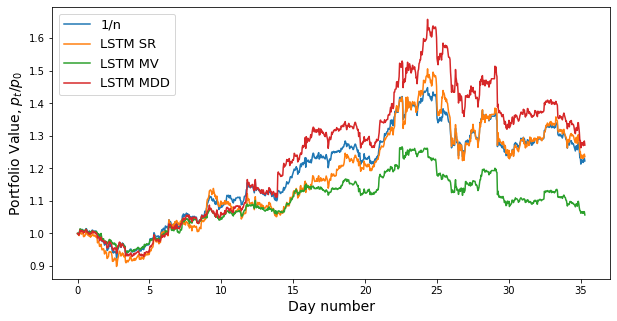

In [23]:
w_lstm_SR, w_lstm_MV, w_lstm_MDD = w_lstm_lab

# set initial portfolio values equal
mean, lstm_SR, lstm_MV, lstm_MDD = [1], [1], [1], [1]
w_mean = np.zeros(num_tokens) + 1/num_tokens

for t in range(0, len(w_lstm_MV)):

    '''
    labels_pred_argmax[t,:] - prediction for prices_test[59+t+10,:]
    '''
    # calculate portfolio value
    p = prices_test[59+(t+1)*10,:] / prices_test[59+(t)*10,:]
    mean.append((p @ w_mean) * mean[t])
    lstm_SR.append((p @ w_lstm_SR[t]) * lstm_SR[t])
    lstm_MV.append((p @ w_lstm_MV[t]) * lstm_MV[t])
    lstm_MDD.append((p @ w_lstm_MDD[t]) * lstm_MDD[t])


num_days = [t*5/6/24 for t in range(0,len(w_lstm_MV)+1)]
# plot results
plt.figure(figsize=(10,5))
plt.plot(num_days, mean,label = '1/n')
plt.plot(num_days, lstm_SR, label = 'LSTM SR')
plt.plot(num_days, lstm_MV, label = 'LSTM MV')
plt.plot(num_days, lstm_MDD, label = 'LSTM MDD')
plt.ylabel('Portfolio Value, $p_t/p_0$', size =14)
plt.xlabel('Day number', size =14)
plt.legend(fontsize=13, loc = 'upper left')
plt.show()

In [0]:
import pandas as pd
# this part of code was taken from https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5

def portfolio_annualised_performance(weights, mean_returns, cov_matrix, N):
    '''
    This function calculates returns and volatility of portfolio

    Parameters:
      weights - weights of portfoio
      mean_returns - mean returns of portfoio
      cov_matrix - covariance matrix
      N - number of trading points
    '''

    returns = np.sum(mean_returns*weights ) * N
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(N)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, num_tokens, data):

    '''
    This function generates random portfoios 
    and calculare their return, volatility and Sharpe Ratio

    Parameters:
      num_portfolios - number of generated portfoios
      mean_returns - mean returns of portfoio
      cov_matrix - covariance matrix
      risk_free_rate - risk free rate
      num_tokens - number of tokens

    '''

    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):

        weights = np.random.random(num_tokens)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix, data.shape[0])
        
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

    return results, weights_record


def find_optimal_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate, data):

     # Generating random portfolios and storing their return, volatility and Sharpe Ratio
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate, data.shape[1], data)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # find portfolios with maximal Sharpe Ratio and minimal volatility
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    b = max_sharpe_allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    return weights[min_vol_idx], weights[max_sharpe_idx]


def Mark(N):
    """
    This function returns two optimal portfolios, determined using Markowitz’s model 
    based on maximum Sharpe Ratio and minimum volatility

    Parameters:
      N - moment of time in wich portfolio weights are calculating
    """

    history_data = np.concatenate((returns_50_train[:,:], returns_50_test[:N,:]), axis = 0)
    data = pd.DataFrame(history_data)

    #returns = data.pct_change()
    mean_returns = data.mean()
    cov_matrix = data.cov()
    N = data.shape[0]
    num_portfolios = 25000 # number of generating portfolios
    risk_free_rate = 0.039 # risk free rate was taken as risk free rate Bitcoin

    min_vol_allocation, max_sharpe_allocation = find_optimal_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate, data)

    return min_vol_allocation/100, max_sharpe_allocation/100


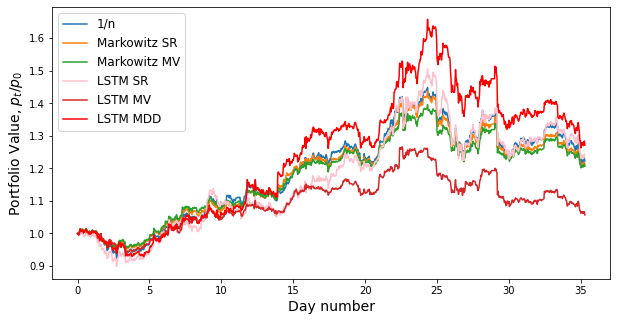

In [25]:
mean, mark_SR, mark_MV = [1], [1], [1]
w_mean = np.zeros(num_tokens) + 1/num_tokens

# calculate weights according to Markowitz model
w_mark_SR, w_mark_MV = Mark(0)
for t in range(0, len(w_lstm_SR)):

    '''
    labels_pred_argmax[t,:] - prediction for prices_test[59+t+10,:]
    '''

    #w_mark_SR, w_mark_MV = Mark(t)
    
    # update portfolio values
    p = prices_test[59+(t+1)*10,:] / prices_test[59+(t)*10,:]
    mean.append((p @ w_mean) * mean[t])
    mark_SR.append((p @ w_mark_SR) * mark_SR[t])
    mark_MV.append((p @ w_mark_MV) * mark_MV[t])

# plot results
plt.figure(figsize=(10,5))
plt.plot(num_days, mean, label = '1/n')
plt.plot(num_days, mark_SR, label = 'Markowitz SR')
plt.plot(num_days, mark_MV, label = 'Markowitz MV')
plt.plot(num_days, lstm_SR, label = 'LSTM SR', color='pink')
plt.plot(num_days, lstm_MV, label = 'LSTM MV')
plt.plot(num_days, lstm_MDD, label = 'LSTM MDD', color = 'red')
plt.legend(fontsize=12, loc = 'upper left')
plt.ylabel('Portfolio Value, $p_t/p_0$', size=14)
plt.xlabel('Day number', size=14)
plt.show()

Development of trading scheme

In [0]:
def naive_rebalance(pred):
      add = 0
      if len(pred[pred == 2]) > 0:
        for i in np.where(pred == 2)[0]:
          add += w[i] 
          w[i] = 0
        if len(pred[pred == 0]) > 0:
          for i in np.where(pred == 0)[0]:
            w[i] += add / len(pred[pred == 0])
        else:
          for i in np.where(pred == 1)[0]:
            w[i] += add / len(pred[pred == 1])
      elif len(pred[pred == 1]) > 0:
        for i in np.where(pred == 1)[0]:
          add += w[i] 
          w[i] = 0
        if len(pred[pred == 0]) > 0:
          for i in np.where(pred == 0)[0]:
            w[i] += add / len(pred[pred == 0])
        else:
          for i in np.where(pred == 1)[0]:
            w[i] += add / len(pred[pred == 1])
      return w


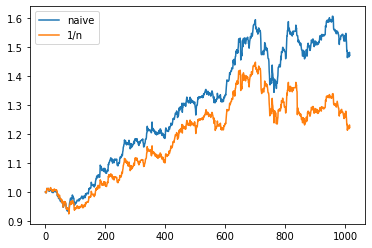

In [0]:
mean, true = [1], [1]
w_mean = np.zeros(num_tokens) + 1/num_tokens
w = w_mean.copy()
w_LOB = []
for t in range(0, int(labels_pred_argmax.shape[0]/10)):

    '''
    labels_pred_argmax[t,:] - prediction for prices_test[59+t+10,:]
    '''
    pred = labels_pred_argmax[t*9,:]
    
    p = prices_test[59+(t+1)*10,:] / prices_test[59+(t)*10,:]
    if (pred).all() == 0:
      w = np.zeros(num_tokens) + 1/num_tokens
      true.append((p @ w) * true[t])
    elif sum(pred) != num_tokens*2:
      w = naive_rebalance(pred)
      true.append((p @ w) * true[t])
    else:
      true.append(true[-1])
    #print(pred, w)
    mean.append((p @ w_mean) * mean[t])
    w_LOB.append

plt.plot(true, label = 'naive')
plt.plot(mean, label = '1/n')

plt.legend()
plt.show()